In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importance of weight initialization

The initialization of the weights of a Neural Network are a key aspect of the training of Neural Networks.



## Question 1
Using the FashionMNIST dataset, train a feed forward neural network with 2 hidden layers, with sizes 64 and 32. Use a cross-entropy loss.

Make sure to enable the initialization of the weights and biases with different methods. You will study the constante, kaiming, uniform, normal and xavier initializations (see `torch.nn.init`)

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.286, 0.353),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = FashionMNIST(
    root='../data', 
    train=True, 
    download=True, 
    transform=train_transforms

)
test_dataset = FashionMNIST(
    root='../data', 
    train=False, 
    download=True, 
    transform=train_transforms
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=64, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=64,
    shuffle=False
)



In [3]:

def train(model : torch.nn.Module, 
          train_loader : DataLoader, 
          optimizer : torch.optim, 
          criterion : callable, 
          device = 'cpu', 
          epochs=5):
    model.train()
    train_losses = []
    for epoch in tqdm(range(epochs)):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data.view(data.size(0),-1))
            
            loss = criterion(output, target)
            train_losses.append(loss.detach().item())
            
            loss.backward()
            optimizer.step()
    
    return train_losses

In [4]:
class FFN(nn.Module):   

    def __init__(self, 
                 input_size : int, 
                 output_size: int, 
                 init: callable = nn.init.xavier_normal_):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size

        self.layer1 = nn.Linear(
            in_features= self.input_size,
            out_features= 64,
        )

        self.relu = nn.ReLU()

        self.layer2 = nn.Linear(
            in_features=64,
            out_features=32
        )

        self.output = nn.Linear(
            in_features=32,
            out_features=self.output_size
        )

        self.initialize_weigths(init)

    def initialize_weigths(self,
                           method : callable = nn.init.xavier_normal_):
        method(self.layer1.weight)
        method(self.layer2.weight)
        
    def forward(self, x: torch.TensorType):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x

In [25]:
model = FFN(28**2,
            10,
            nn.init.xavier_normal_)

optimizer = torch.optim.Adam(
    model.parameters(),
    1e-4
)

loss_fn = torch.nn.CrossEntropyLoss()

history_xavier = train(
    model,
    train_loader,
    optimizer,
    loss_fn,
    device='cpu'
)

100%|██████████| 5/5 [01:06<00:00, 13.24s/it]


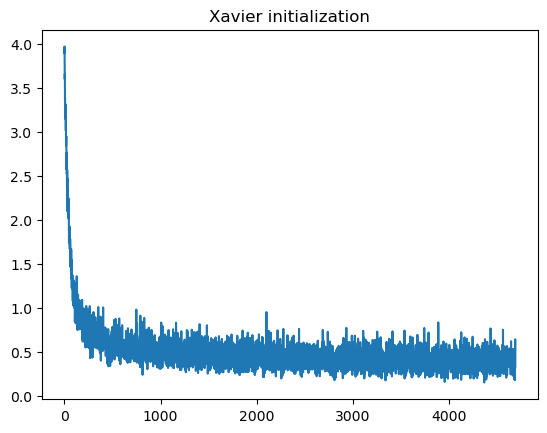

In [30]:
plt.title("Xavier initialization")
plt.plot(history_xavier)

In [31]:
model_zeros = FFN(28**2,
            10,
            nn.init.zeros_)

optimizer = torch.optim.Adam(
    model_zeros.parameters(),
    1e-4
)

loss_fn = torch.nn.CrossEntropyLoss()

history_zeros = train(
    model,
    train_loader,
    optimizer,
    loss_fn,
    device='cpu'
)

100%|██████████| 5/5 [01:04<00:00, 12.83s/it]


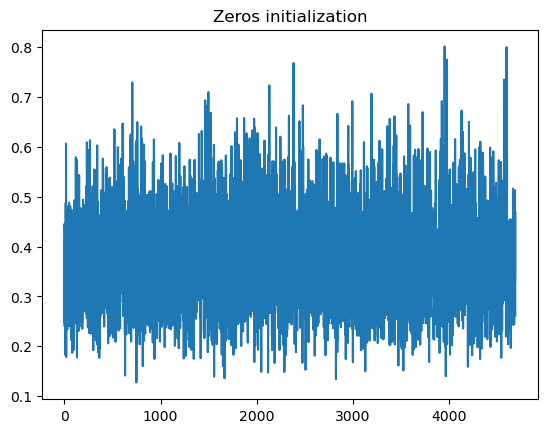

In [32]:
plt.title("Zeros initialization")
plt.plot(history_zeros)

In [33]:
model_unif = FFN(28**2,
            10,
            nn.init.uniform_)

optimizer = torch.optim.Adam(
    model_zeros.parameters(),
    1e-4
)

loss_fn = torch.nn.CrossEntropyLoss()

history_unif = train(
    model,
    train_loader,
    optimizer,
    loss_fn,
    device='cpu'
)

100%|██████████| 5/5 [01:10<00:00, 14.11s/it]


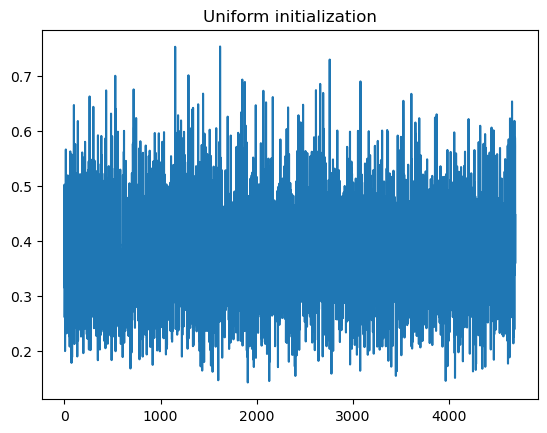

In [34]:
plt.title("Uniform initialization")
plt.plot(history_unif)


## Question 2
Plot the different training losses and compare the different initializations

In [6]:


def train_and_plot_all_inits(
    train_loader: DataLoader, 
    criterion: callable, 
    device, 
    inits : dict, 
    epochs: int =1, 
    lr=3e-3
):
    results = {}
    for init_name, init_method in inits.items():
        model = FFN(28**2,
                    10,
                    init= init_method)
        
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr
        )

        history = train(model,
              train_loader,
              optimizer,
              criterion,
              device,
              epochs= epochs)
        
        results[init_name] = history


    return results


criterion = nn.CrossEntropyLoss()
inits = {
    "xavier_normal" : torch.nn.init.xavier_normal_,
    "zeros" : torch.nn.init.zeros_,
    "uniform" : torch.nn.init.uniform_,
    "normal": torch.nn.init.normal_ 

} 

results = train_and_plot_all_inits(train_loader, criterion, device, inits)

100%|██████████| 1/1 [00:13<00:00, 13.86s/it]


<Axes: title={'center': 'Weight initialization impacts on optimization'}>

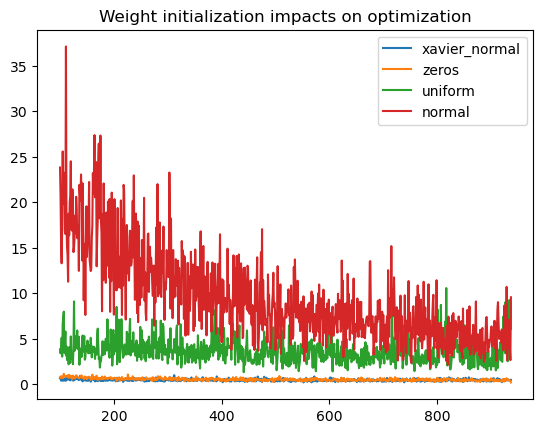

In [14]:
pd.DataFrame(results)\
    .iloc[100:]\
    .plot(
        title= "Weight initialization impacts on optimization"
    )